# Embedded ML - Lab 2.3: TensorFlow Lite Micro

*Santiago Vargas Higuera*

*Daniel Santiago Arcila*

Tensor Flow Lite Micro (TFLM) is a library that aims to run ML models efficiently on embedded systems. It's a C++ library that provides a version of the TensorFlow Lite interpreter that supports less types of operations and uses less memory. The library also provides helper functions for data pre- and post-processing.

### Learning outcomes


* Explain the basic concepts associated with TFLM
* Use the API to implement the TFLM workflow for an embedded application
* Execute TFLM code on a microcontroller-based embedded system

### TensorFlow Lite Micro workflow

TFLM's high-level workflow is rather simple:
* Generate a small TensorFlow model that can fit your target device and contains supported operations.
* Convert to a TensorFlow Lite model using the TensorFlow Lite converter, applying quantization if required.
* Convert to a C byte array using standard tools and stored it in the read-only program memory on device.
* Run inference on device using the TFLM C++ library and process the results.

### Hello World and Hello Human

After installing the Arduino IDE and the board files, you should install the Harvard_TinyMLx library that contains the TensorFlow Lite Micro and other resources and examples to build ML apps with Arduino and TFLM. Later on, depending on the application you want to build and the specific hardware to be used, you should install the propper peripheral drivers for communication, sensing and actuating.



*   Install Arduino IDE 2 from: https://downloads.arduino.cc/arduino-ide/arduino-ide_2.3.2_Linux_64bit.AppImage
*   From the boards manager install: Arduino Mbed OS Nano boards
*   Allow the linux user to access serial port: `sudo usermod -a -G dialout \<username\>` (reboot afterwards)
*   From the library manager install: Harvard_TinyMLx




Now open the **Hello World** example from the Harvard_TinyMLx library File->Examples->Harvard_TinyMLx in Arduino IDE (also available in [this repo](https://github.com/tinyMLx/arduino-library/tree/main/examples/hello_world)), compile it and run it on the microcontroller board. It is an ML model to predict a sine wave that is used to dim on and off an LED. The Arduino IDE serial monitor should also show interger numbers up and down trying to model a sine wave. This is a test app to make sure that the basic HW and SW elements, including TFLM, are working.

Inspect the code to make sure you identify and understand the main parts of the workflow.

Running on-device inference using the TFLM C++ library usually involves:

* Include the library headers
* Include the model header
* Load a model
* Instantiate operations resolver
* Allocate memory
* Instantiate interpreter
* Read and pre-process input data
* Provide inputs to the allocated tensors
* Run inference
* Get results from the output tensors
* Take action based on outputs

After you have succesfully run the Hello World example, move on to running the **Person Detection** example from the same library. Explore the code in detail to understand how to handle the **camera**.

### TinyML application development

ML applications that run on embeded systems with very limited resources are often called TinyML. In this lab the goal is to develop a simple TinyML application that uses computer vision up to its deployment on the target embedded device: **Arduino Nano 33 BLE.**

Follow these steps in order to develop your TinyML application:

1. Select two visual objects that are radically different and  assemble a dataset that contains at least hundreds or thousands of examples. You can create the images yourslef or extract them from a public database and apply data augmentation.

2. Design and train a model to classify between the two chosen objects. You can build a dense or CNN model from scratch, or use transfer learning, but you should always keep in mind the very limited memory resources of the target device as well as the image properties of the embedded camera.

3.   Export the trained model to a file and convert it to a C header by running the following linux command: `xxd -i converted_model.tflite > converted_model_data.h`

4.   Develop an Arduino code based on the Hello World and Person Detection examples, to detect whether any of the two objects are present on the camera view. Indicate the result through the RGB LED.

Include in your notebook submission both the code you developed to build the model as well as the C++ codes for the MCU.

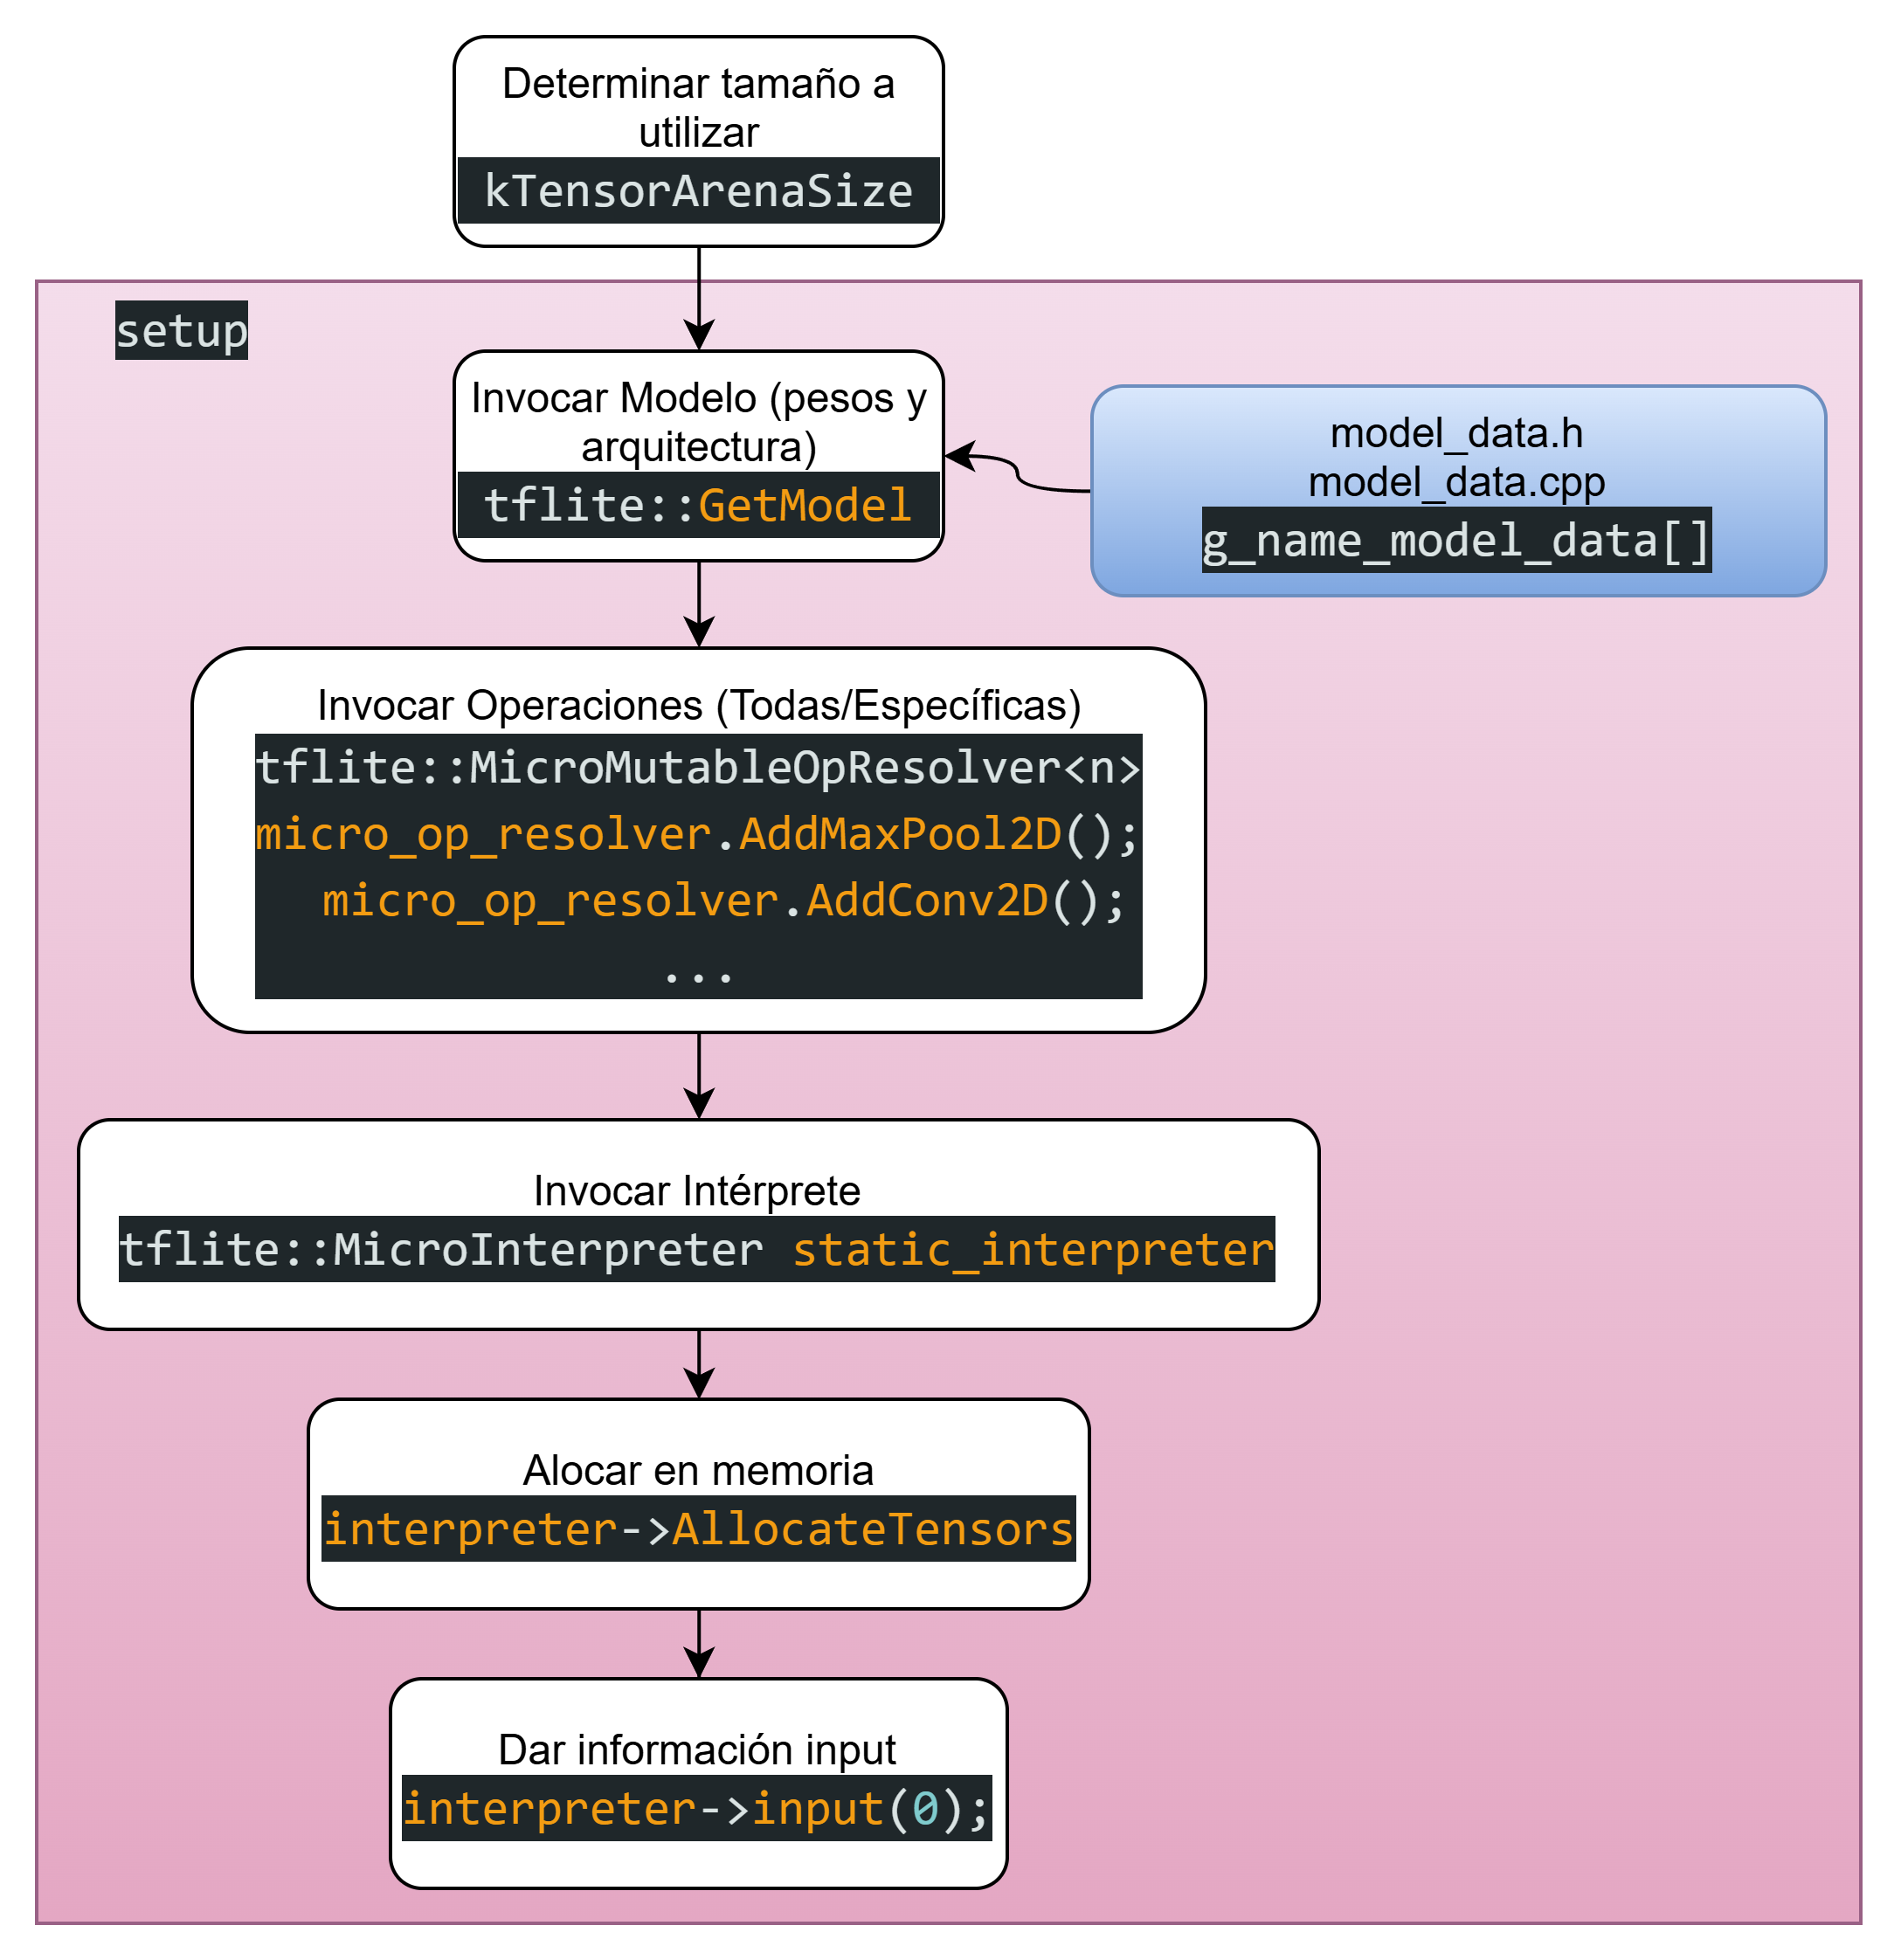

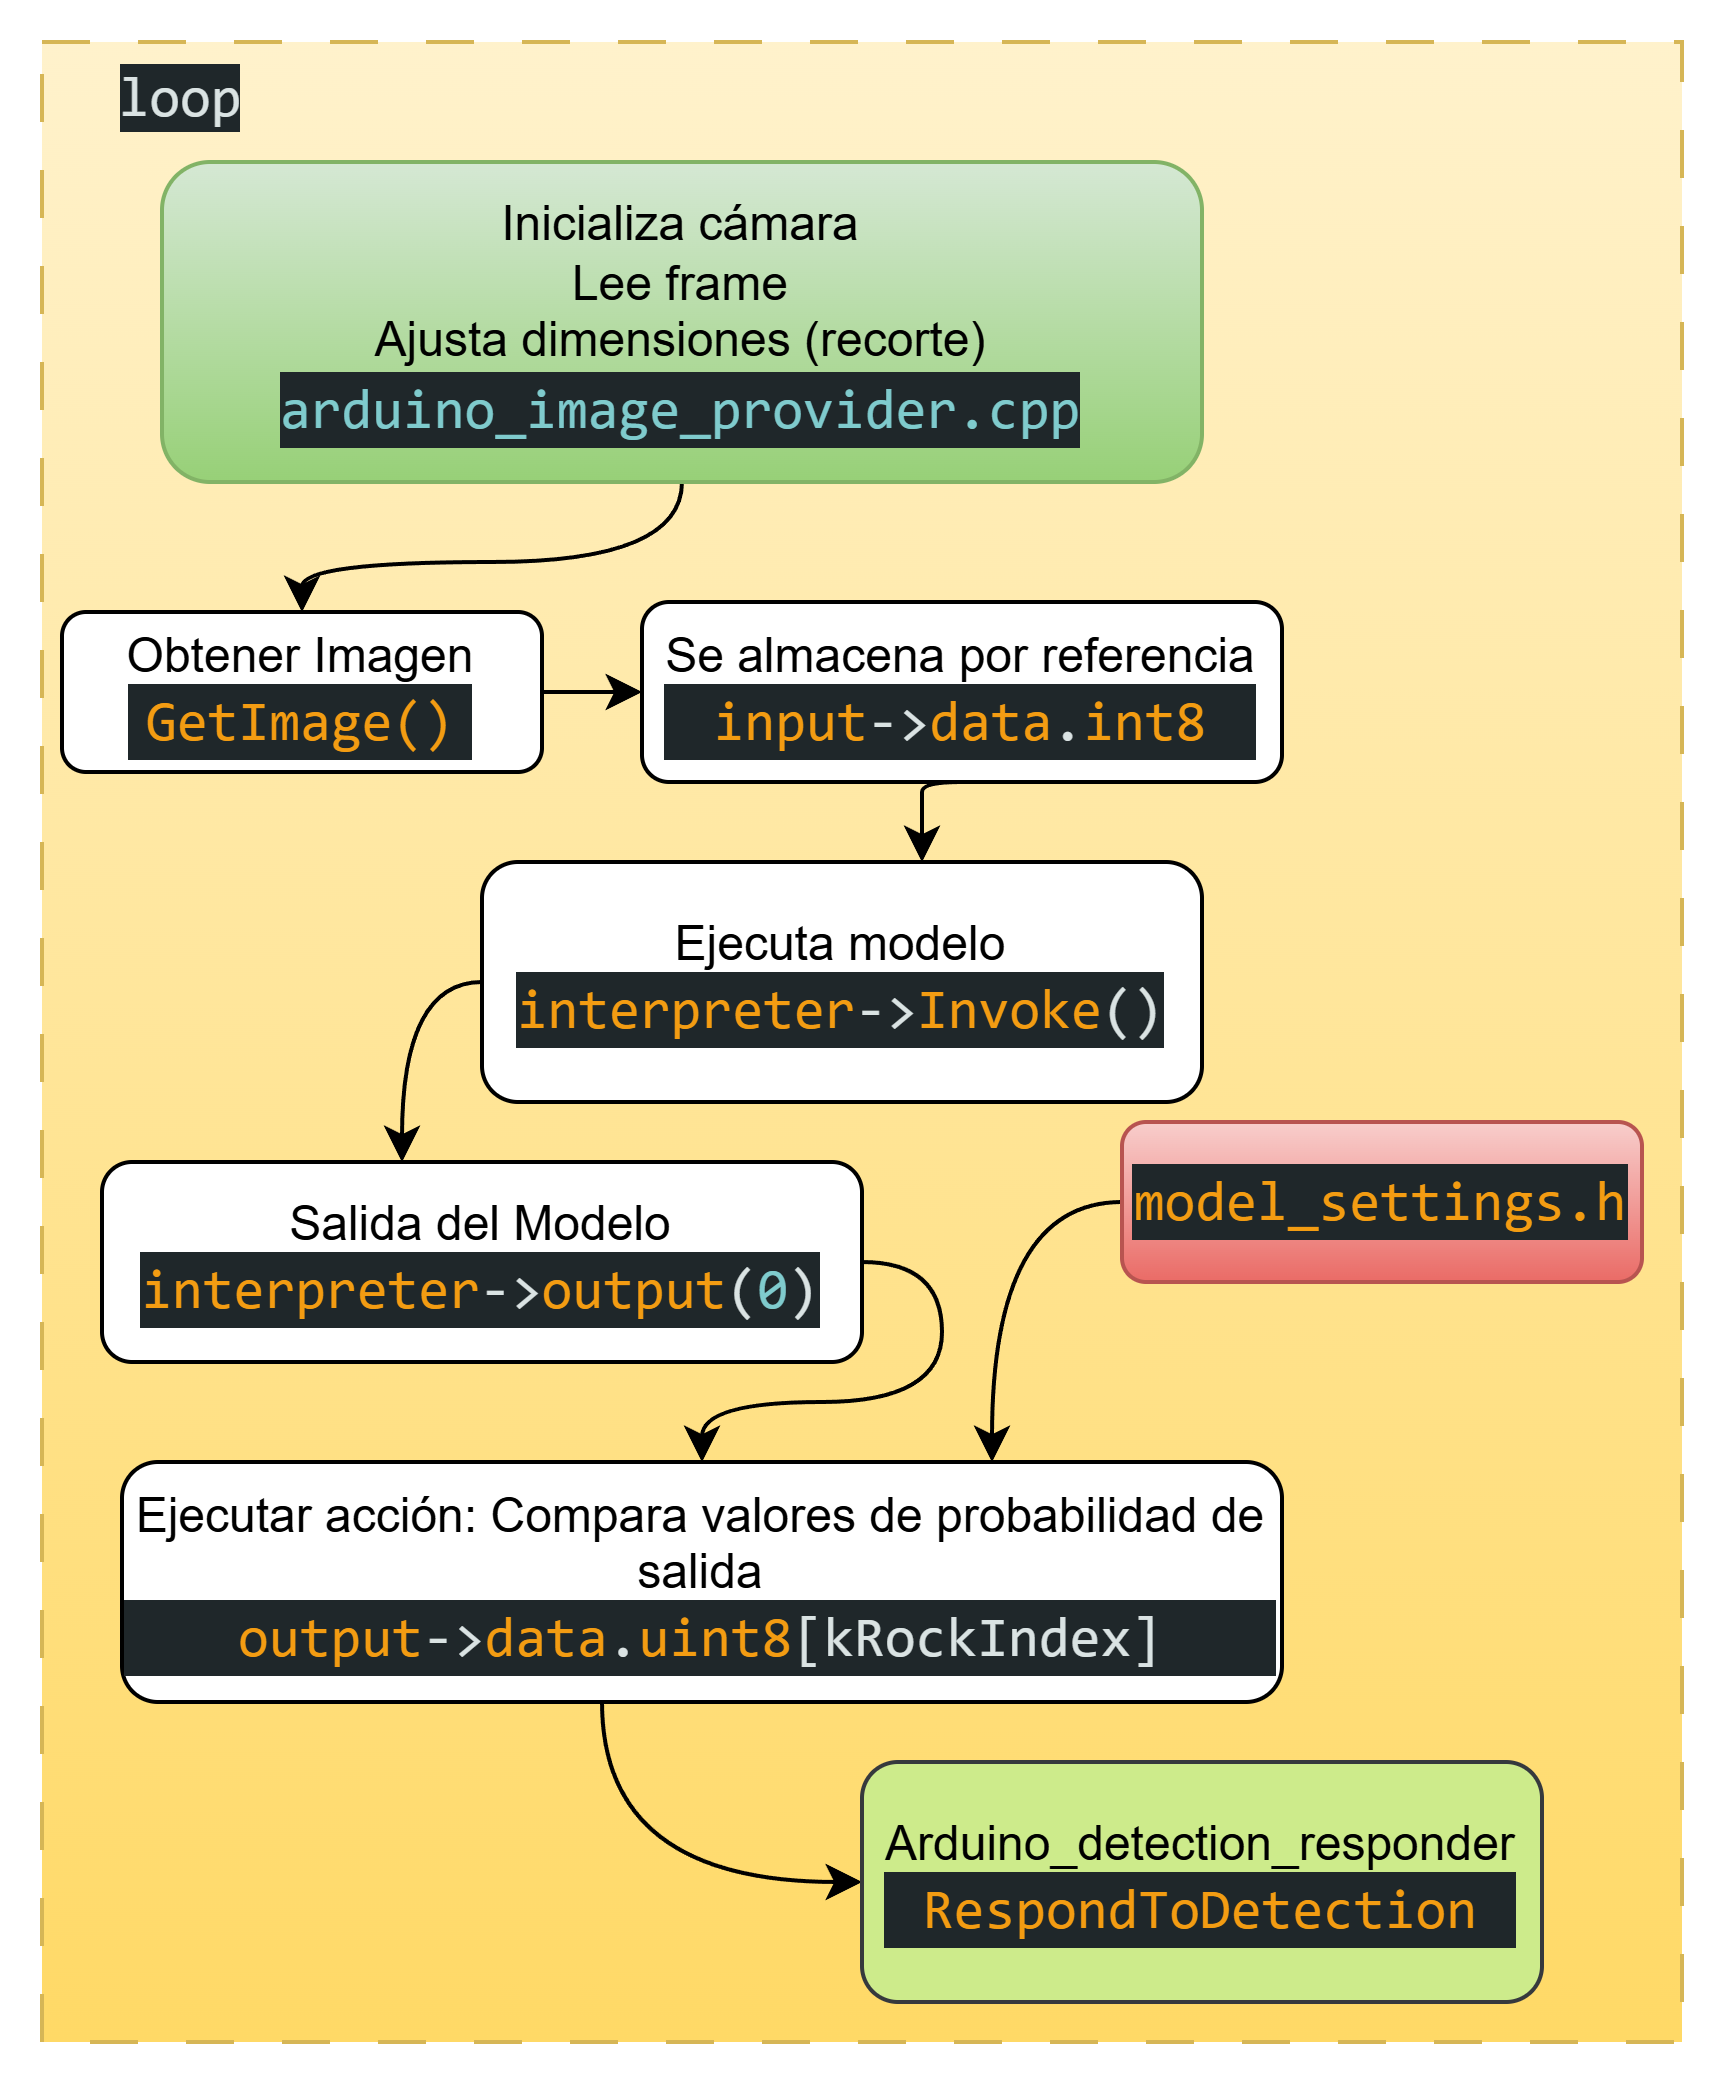



> **Repositorio con código de Arduino:** https://github.com/santiagov01/Lab-EML/tree/main/Lab2/Lab2.3-TF-Lite-Micro/rock_paper_class





## 1. Load Dataset

In [ ]:
import kagglehub
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet

import time
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

# Define the destination directory
destination_dir = "/content/dataset/"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Move the downloaded files to the destination directory
!mv {path}/* {destination_dir}

print(f"Dataset downloaded and moved to: {destination_dir}")
!ls {destination_dir}
path  = os.path.join(path,destination_dir)

mv: inter-device move failed: '/kaggle/input/rockpaperscissors/paper' to '/content/dataset/paper'; unable to remove target: Directory not empty
mv: cannot remove '/kaggle/input/rockpaperscissors/README_rpc-cv-images.txt': Read-only file system
mv: inter-device move failed: '/kaggle/input/rockpaperscissors/rock' to '/content/dataset/rock'; unable to remove target: Directory not empty
mv: cannot remove '/kaggle/input/rockpaperscissors/rps-cv-images/paper/cQ0dBO3yHPohZ9U9.png': Read-only file system
mv: cannot remove '/kaggle/input/rockpaperscissors/rps-cv-images/paper/jAh36hlZLpECSBHp.png': Read-only file system
mv: cannot remove '/kaggle/input/rockpaperscissors/rps-cv-images/paper/QnjBVl6cFnyd2hVF.png': Read-only file system
mv: cannot remove '/kaggle/input/rockpaperscissors/rps-cv-images/paper/dZh2VMRu9nRGHhYL.png': Read-only file system
mv: cannot remove '/kaggle/input/rockpaperscissors/rps-cv-images/paper/SDQQfzHl47yNqA6K.png': Read-only file system
mv: cannot remove '/kaggle/input/r

In [ ]:
#Delete sissor's image
!rm -r '/content/dataset/scissors'
!rm -r '/content/dataset/rps-cv-images'
!rm -r '/content/dataset/sample_data'

#Delete sissor's labels
!rm -r '/content/dataset/rps-cv-images/scissors'

rm: cannot remove '/content/dataset/sample_data': No such file or directory
rm: cannot remove '/content/dataset/rps-cv-images/scissors': No such file or directory


### Process Dataset

In [ ]:


base_dir = "/content/dataset/"

# Define the directories for rock and paper images
rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')

# Check the number of images in each directory
print('total rock images:', len(os.listdir(rock_dir)))
print('total paper images:', len(os.listdir(paper_dir)))

# Create a dataset from the directories
# Use image_dataset_from_directory for easy loading
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='binary', # Binary classification
    image_size=(96, 96), # Resize images to 96x96
    interpolation='nearest',
    batch_size=32, # Use a batch size of 32
    shuffle=True, # Shuffle the data
    color_mode = 'grayscale'
)
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

# Get the total number of samples in the dataset
num_samples = tf.data.experimental.cardinality(dataset).numpy() * 32 # Multiply by batch size

# Calculate the sizes for training, validation, and test sets
train_size = int(0.7 * num_samples)
validation_size = int(0.15 * num_samples)
test_size = int(0.15 * num_samples)

if train_size + validation_size + test_size != num_samples:
    remaining = num_samples - train_size
    validation_size = int(0.5 * remaining)
    test_size = remaining - validation_size


print(f"Total samples: {num_samples}")
print(f"Train samples: {train_size}")
print(f"Validation samples: {validation_size}")
print(f"Test samples: {test_size}")

# Split the dataset
train_ds = dataset.take(train_size // 32) # Take batches for training
validation_ds = dataset.skip(train_size // 32).take(validation_size // 32) # Skip train batches and take validation batches
test_ds = dataset.skip((train_size + validation_size) // 32) # Skip train and validation batches and take test batches


num_classes = 2

total rock images: 726
total paper images: 712
Found 1438 files belonging to 2 classes.
Total samples: 1440
Train samples: 1007
Validation samples: 216
Test samples: 217


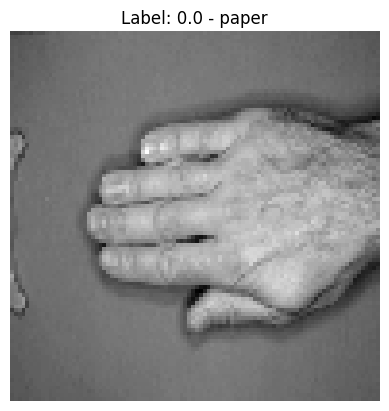

In [ ]:
#visualizar un dato
clases_names = ['paper', 'rock']
for images, labels in train_ds.take(1):
    first_image = images[0]
    first_label = labels[0]
    plt.imshow(tf.squeeze(first_image.numpy()), cmap='gray')
    plt.title(f"Label: {first_label[0]} - {clases_names[int(first_label[0])]}")
    plt.axis('off')
    plt.show()

In [ ]:
img_width, img_height = 96, 96
batch_size = 32

def augment(image, label):
  # Aplicar volteo horizontal aleatorio
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

  return image, label

# Aplica la función de aumento solo al dataset de entrenamiento
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
augmen = tf.keras.layers.RandomRotation(0.15)

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
val_ds   = validation_ds.map(lambda x, y: (augmen(x), y))
# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2.a. Model1 Design

In [ ]:

model1 = models.Sequential([
    layers.Input(shape=(96, 96, 1)),  # Adjust shape to your image_size
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dense(32, activation='relu'),
    #layers.Dense(1 if num_classes == 2 else num_classes,
    #             activation='sigmoid' if num_classes == 2 else 'softmax')
    layers.Dense(num_classes, activation='softmax')
])
model1.compile(
    optimizer='adam',
    #loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,434 (103.26 KB)

 Trainable params: 26,434 (103.26 KB)

 Non-trainable params: 0 (0.00 B)

### 2.1 Training

In [ ]:
model1.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=15
)

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9818 - loss: 0.0584 - val_accuracy: 0.9948 - val_loss: 0.0210
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9774 - loss: 0.0556 - val_accuracy: 0.9948 - val_loss: 0.0197
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9866 - loss: 0.0602 - val_accuracy: 0.9844 - val_loss: 0.0314
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9883 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.0252
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9800 - loss: 0.0639 - val_accuracy: 0.9948 - val_loss: 0.0228
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9800 - loss: 0.0621 - val_accuracy: 0.9948 - val_loss: 0.0219
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9790 - loss: 0.0668 - val_accuracy: 0.9740 - val_loss: 0.0929
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9788 - loss: 0.0753 - val_accuracy: 0.9844 - val_loss:

In [ ]:
# evaluar modelo
test_loss, test_acc = model1.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9879 - loss: 0.0184
Test accuracy: 0.9864864945411682


## 2.2. Convertir a TFLite

In [ ]:
# Adecuate data set to being unbatched
unbatched_dataset = test_ds.unbatch()
model1.save('paper_rock_model.keras')
saved_model_dir = 'paper_rock_model.keras'

model = tf.keras.models.load_model(saved_model_dir)
# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply integer quantization
# This requires a representative dataset for calibration
def representative_data_gen():
  for input_value, _ in unbatched_dataset.take(100):
    # Convert the input image to float32 and normalize to [0, 1]
    input_value = tf.cast(input_value, tf.float32)
    #tipo de valor

    input_value = (tf.expand_dims(input_value, axis=0)).numpy()
    yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

path = 'quantized_model.tflite'

# Save the quantized model to a file
with open(path, 'wb') as f:
    f.write(tflite_model)

#print size file
print(os.path.getsize(path))

Saved artifact at '/tmp/tmp68coatkw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132605710657168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710661584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710661200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710661776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710660048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710657744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710663504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710659088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710658704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132605710662736: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


34608


## 3. Export Trained Model

In [ ]:
!xxd -i quantized_model.tflite > converted_model_data.h

## 4. Run Inference Lite

In [ ]:
def tflite_interpreter(tf_lite_path):
  interpreter = tf.lite.Interpreter(model_path=tf_lite_path)
  interpreter.allocate_tensors()

  # Set input values
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  return interpreter, input_details, output_details
def tf_lite_inference(interpreter, input_details, output_details, data):
  input_dtype = input_details[0]['dtype']
  if input_dtype == np.uint8:
    # Handle uint8 quantization (as originally implemented)
    input_scale, input_zero_point = input_details[0]['quantization']
    to_predict = data / input_scale + input_zero_point
    to_predict = np.clip(to_predict, 0, 255).astype(np.uint8)
  elif input_dtype == np.int8:
    # int8 quantization
    input_scale, input_zero_point = input_details[0]['quantization']
    # Cast data to float32 first for scaling, then to int8
    to_predict = np.array(data, dtype=np.float32) / input_scale + input_zero_point
    to_predict = np.clip(to_predict, -128, 127).astype(np.int8) # int8 range is -128 to 127
  elif input_dtype == np.float16:
    to_predict = np.array(data, dtype=np.float16)
  else:
    # float32 input
    to_predict = np.array(data, dtype=np.float32)

  #to_predict = np.array(data, dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], to_predict)
  # Run inference
  interpreter.invoke()
  # Get outputs
  tflite_results = interpreter.get_tensor(output_details[0]['index'])
  return tflite_results

def evaluate_tflite_model(saved_tflite_model, unbatched_dataset):
  acc = 0
  N = 0
  for element in unbatched_dataset:
    N += 1
  print(N)
  init = time.time()
  interpreter, input_details, output_details = tflite_interpreter(saved_tflite_model)

  for image, label in unbatched_dataset.take(N):
    # Get the first image from the batch
    single_label = label.numpy()
    #print(image)
    image =  (tf.expand_dims(image, axis=0)).numpy()
    #print(image)
    results = tf_lite_inference(interpreter,
                                input_details,
                                output_details,
                                data=image)
    predicted = np.argmax(results)
    original = single_label

    if predicted == original:
      #print('Correct')
      acc+=1
    # else:
    #   #print('Incorrect')
    # print('---------')

  print(results)
  print(type(results[0][0]))

  print(f'accuracy = {(acc/N)*100}%')
  end_time = (time.time()-init)/N
  print(f'Average time: {end_time}')
  return acc/N, end_time


In [ ]:
acc_quant, time_quant = evaluate_tflite_model('quantized_model.tflite', unbatched_dataset)

222
[[-128  127]]
<class 'numpy.int8'>
accuracy = 99.09909909909909%
Average time: 0.002954346639615995


[[-128  127]]


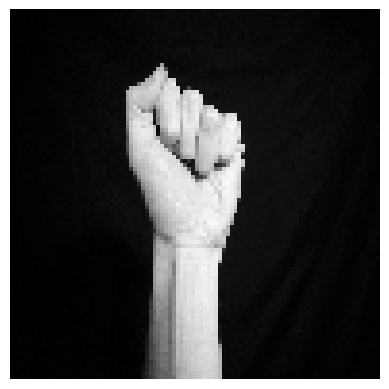

In [ ]:
img_path = 'rock1.jpeg'

img = image.load_img(img_path, target_size=(96, 96), color_mode='grayscale')
plt.imshow(img, cmap='gray')
plt.axis('off')

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale like the training data

#img_array = np.array(img_array,np.int8)

interpreter, input_details, output_details = tflite_interpreter('quantized_model.tflite')
results = tf_lite_inference(interpreter,
                            input_details,
                            output_details,
                            data=img_array)
print(results)

## 2.b. Model2 Design

In [ ]:

np.expand_dims(train_ds, axis=0)
np.expand_dims(validation_ds, axis=0)

train_ds2 = train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
validation_ds2 = validation_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))


base_model = MobileNet(weights='imagenet', include_top=False,alpha=0.25, input_shape=(96, 96,3))

base_model.trainable = False

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2.summary()


<ipython-input-29-2813664421>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False,alpha=0.25, input_shape=(96, 96,3))


2108140/2108140 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_0.25_224 (Functional) │ (None, 3, 3, 256)      │       218,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,801 (854.69 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 218,544 (853.69 KB)

In [ ]:
model2.fit(
    train_ds2,
    validation_data=validation_ds2,
    epochs=10
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.6331 - loss: 0.7266 - val_accuracy: 0.8906 - val_loss: 0.3565
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8776 - loss: 0.3350 - val_accuracy: 0.9740 - val_loss: 0.2054
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9713 - loss: 0.1940 - val_accuracy: 0.9896 - val_loss: 0.1482
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9846 - loss: 0.1405 - val_accuracy: 0.9896 - val_loss: 0.1008
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9909 - loss: 0.1109 - val_accuracy: 0.9896 - val_loss: 0.0865
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.9935 - loss: 0.0900 - val_accuracy: 0.9948 - val_loss: 0.0900
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9940 - loss: 0.0760 - val_accuracy: 0.9896 - val_loss: 0.0765
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9938 - loss: 0.0656 - val_accuracy: 0

In [ ]:
import copy

test_ds2 = test_ds
np.expand_dims(test_ds2, axis=0)
test_ds2 = test_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
model2.evaluate(test_ds2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 1.0000 - loss: 0.0448


[0.04026775807142258, 1.0]

### Test New Data - Model2

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: paper
Raw prediction score: 0.42396777868270874


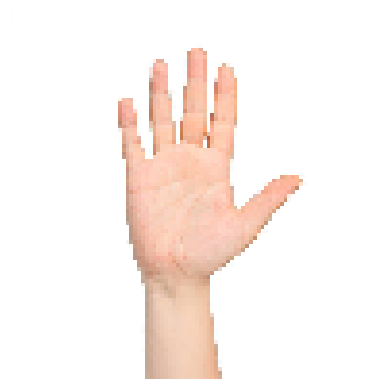

In [ ]:
from tensorflow.keras.preprocessing import image

# Assuming 'model2' is already trained from the preceding code
# Load the image
img_path = 'papel2.jpg'

img = image.load_img(img_path, target_size=(96, 96), color_mode='rgb')
plt.imshow(img, cmap='gray')
plt.axis('off')

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale like the training data


# Make prediction
predictions = model2.predict(img_array)

# Get the predicted class
# For binary classification with sigmoid output
predicted_class = (predictions > 0.5).astype("int32")

# Map the prediction to the original class names
class_names = ['paper', 'rock']

if predicted_class[0][0] == 0:
    print(f"Prediction: {class_names[0]}")
else:
    print(f"Prediction: {class_names[1]}")

print(f"Raw prediction score: {predictions[0][0]}")

In [ ]:

# Assuming 'model2' is already trained from the preceding code
# Load the image
img_path = 'papel2.png'

img = image.load_img(img_path, target_size=(96, 96), color_mode='rgb')
plt.imshow(img, cmap='gray')
plt.axis('off')

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale like the training data


# Make prediction
predictions = model2.predict(img_array)

# Get the predicted class
# For binary classification with sigmoid output
predicted_class = (predictions > 0.5).astype("int32")

# Map the prediction to the original class names
# Assuming your dataset labels were 'paper' (0) and 'rock' (1) based on directory order
class_names = ['paper', 'rock']

if predicted_class[0][0] == 0:
    print(f"Prediction: {class_names[0]}")
else:
    print(f"Prediction: {class_names[1]}")

print(f"Raw prediction score: {predictions[0][0]}")

In [ ]:

# Assuming 'model2' is already trained from the preceding code
# Load the image
img_path = 'piedra2.png'

img = image.load_img(img_path, target_size=(96, 96), color_mode='rgb')
plt.imshow(img, cmap='gray')
plt.axis('off')

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale like the training data


# Make prediction
predictions = model2.predict(img_array)

# Get the predicted class
# For binary classification with sigmoid output
predicted_class = (predictions > 0.5).astype("int32")

# Map the prediction to the original class names
# Assuming your dataset labels were 'paper' (0) and 'rock' (1) based on directory order
class_names = ['paper', 'rock']

if predicted_class[0][0] == 0:
    print(f"Prediction: {class_names[0]}")
else:
    print(f"Prediction: {class_names[1]}")

print(f"Raw prediction score: {predictions[0][0]}")

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):  # Take one batch
    first_image = images[2]
    first_label = labels[2]
    # Display the image (assuming grayscale)
    plt.imshow(tf.squeeze(first_image.numpy()), cmap='gray')
    if(first_label==1):
      plt.title(f"Label: rock")
    else:
      plt.title(f"Label: paper")
    plt.axis('off')
    plt.show()

#first_image[0]